### Import and plot pyannote speaker diarization pipeline results

In [ ]:
from rttm import read_rttm
from pyannote.core import Annotation, Timeline, Segment
from pyannote.metrics.diarization import DiarizationErrorRate, DiarizationCoverage, DiarizationPurity
import seaborn as sns
import pandas as pd
import numpy as np
import os

In [128]:
RESULTS = ["pyannote"]
FILE_INDICES = list(range(16))

In [129]:
diarization_der = DiarizationErrorRate(collar=0.25)
diarization_der_skip = DiarizationErrorRate(collar=0.25, skip_overlap=True)
diarization_coverage = DiarizationCoverage(collar=0.25)
diarization_purity = DiarizationPurity(collar=0.25)


In [130]:
def convert_rttm_annotation(rttm_seq):
    annotation = Annotation()
    for seg in rttm_seq.sequence:
        annotation[Segment(seg.tbeg, seg.tbeg+seg.tdur)] = seg.name

    return annotation

In [131]:
results_df = {"metric": [], "method": [], "value": []}

method_labels = {
    "pyannote": "pa"
}

for res_dir in RESULTS:
    for i in FILE_INDICES:
        res_rttm_seq = read_rttm(os.path.join('results',res_dir,f"{method_labels[res_dir]}_ami_micro_test_sample_{i}.rttm"))
        ref_rttm_seq = read_rttm(os.path.join(
            "results", "reference", f"ref_ami_micro_test_sample_{i}.rttm"))
        res_annotation = convert_rttm_annotation(res_rttm_seq)
        ref_annotation = convert_rttm_annotation(ref_rttm_seq)
        der = diarization_der(ref_annotation, res_annotation)
        der_skip = diarization_der_skip(ref_annotation, res_annotation)
        coverage = diarization_coverage(
            ref_annotation, res_annotation)
        purity = diarization_purity(
            ref_annotation, res_annotation)

        results_df["metric"] = results_df["metric"] + \
            ["der", "der_skip", "coverage", "purity"]
        results_df["method"] = results_df["method"] + \
            [method_labels[res_dir]] *4
        results_df["value"] = results_df["value"] + \
            [der, der_skip, coverage, purity]

results_df = pd.DataFrame(results_df)

/Users/evaviviani/opt/anaconda3/lib/python3.9/site-packages/pyannote/metrics/utils.py:183: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(


In [133]:
results_df.head()

,metric,method,value
0,der,pa,0.416895
1,der_skip,pa,0.310801
2,coverage,pa,0.679236
3,purity,pa,0.726872
4,der,pa,0.266115


In [ ]:
results_df.to_csv("pyannote_results.csv", index=False)

In [134]:
def select_min_max(group):
    if pd.DataFrame(group).reset_index()["metric"].apply(lambda x: x in ["der", "der_skip"]).all():
        return np.min(group)
    else:
        return np.max(group)

In [135]:
mean_results_df = results_df.groupby(
    ["metric", "method"]).aggregate(np.mean)
mean_best_results_dict = mean_results_df.groupby(
    [ "metric"]).aggregate(select_min_max).to_dict()["value"]

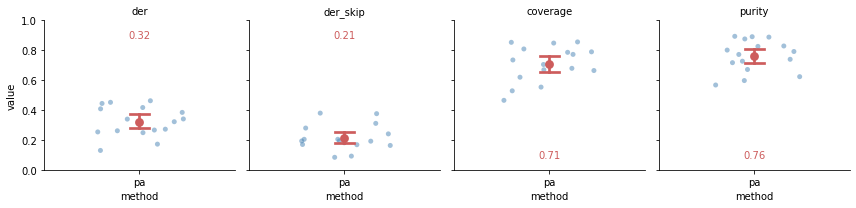

In [136]:
grid = sns.FacetGrid(data=results_df, col="metric")

grid.map(sns.stripplot, "method", "value", color="steelblue",
         order=method_labels.values(), alpha=0.5, jitter=0.25, zorder=1)
grid.map(sns.pointplot, "method", "value", color="indianred", join=False,
         order=method_labels.values(), estimator=np.mean, capsize=0.1, zorder=2)

grid.set_titles(col_template="{col_name}", row_template="{row_name}")
grid.set(ylim=(0.0, 1.0), yticks=np.linspace(0.0, 1.0, 6))

best_pos = {"der": (0, 0.9), "der_skip": (0, 0.9),
            "coverage": (0, 0.1), "purity": (0, 0.1)}

for col in grid.axes:
    for row in col:
        metric = row.title.get_text()
        best = round(mean_best_results_dict[metric], 2)
        row.annotate(text=best, xy=best_pos[metric],
                     ha='center', va='center', color="indianred")
